In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import tqdm

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

try:
    import optuna
    from optuna.visualization import plot_optimization_history
except:
    !pip install -q optuna
    import optuna
    from optuna.visualization import plot_optimization_history

#### Промышленность. Предсказание температуры сплава на металлургическом комбинате.

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Задача проекта — построить модель, которая будет её предсказывать на основе данных, полученных на этапах обработки соответствующих партий стали.

#### Шаг 1. Загрузка данных

In [4]:
RANDOM_STATE = 21082023
PATH = './'
DEVICE = 'cuda'

In [5]:
db_config = {
    'user': 'praktikum_student', # имя пользователя,
    'pwd': 'Sdf4$2;d-d30pp', # пароль,
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения,
    'db': 'data-science-final' # название базы данных,
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string)

#### Шаг 2. Исследовательский анализ и предобработка данных

###### steel.data_temp

In [6]:
query = '''
SELECT *
FROM steel.data_temp
'''

data_temp = pd.read_sql_query(query, con=engine)
data_temp['MesaureTime'] = pd.to_datetime(data_temp['MesaureTime'], format='%H:%M:%S').dt.time

In [7]:
display(data_temp.head())
display(data_temp.info())
display(data_temp.describe())

key MesaureTime  Temperature
0    1    11:16:18       1571.0
1    1    11:25:53       1604.0
2    1    11:29:11       1618.0
3    1    11:30:01       1601.0
4    1    11:30:39       1613.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          15907 non-null  int64  
 1   MesaureTime  15907 non-null  object 
 2   Temperature  13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

key   Temperature
count  15907.000000  13006.000000
mean    1607.880870   1591.840920
std      942.212073     21.375851
min        1.000000   1191.000000
25%      790.000000   1581.000000
50%     1618.000000   1591.000000
75%     2427.000000   1601.000000
max     3241.000000   1705.000000

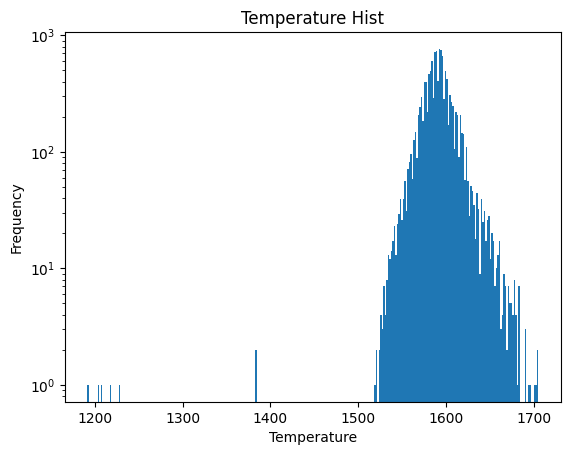

In [8]:
data_temp['Temperature'].plot(kind='hist', bins=300)
plt.yscale('log')
plt.xlabel('Temperature')
plt.title('Temperature Hist')
plt.show()

# заметим, что есть небольшое количество наблюдений с температурой приблизительно выше 1670
# а также просадки, скорее всего связанные с округлением значений

In [9]:
# проверим, упорядоченны ли значения по времени внутки партий (key)
# значение больше 0 - есть немонотонные "куски", 0 - все отлично
(~data_temp.groupby('key')['MesaureTime'].is_monotonic_increasing).mean()

0.022077114427860697

In [10]:
# отсортируем данные по времени внутри партий
data_temp.sort_values(['key', 'MesaureTime'], inplace=True)

# проверим порядок внутри групп еще раз
(~data_temp.groupby('key')['MesaureTime'].is_monotonic_increasing).mean()

0.0

In [11]:
# пропуски как таковые не несут больших рисков в представленных данных
# но если бездумно удалить пропуски мы можем оказаться в ситуации, когда
# промежуточное измерение оказалось первым или последним, что нарушает общую логику проекта
# таким образом, нам надо убедиться, что пропуски не затрагивают первое и/или последнее измерение температуры

first_na = data_temp.groupby('key')['Temperature'].agg(lambda x: x.isna().iat[0])
first_na.name = 'first_na'
display(first_na.sum())

last_na = data_temp.groupby('key')['Temperature'].agg(lambda x: x.isna().iat[-1])
last_na.name = 'last_na'
display(last_na.sum())

# даже если откажемся от первого замера температуры как от дополнительного признака, то
# 'спасем' не очень много партий

17

735

In [12]:
# тут же проверим, чтобы в партии было 2 или более наблюдений
key_len = data_temp.groupby('key')['Temperature'].agg(lambda x: len(x) < 2)
key_len.name = 'key_len'
display(key_len.sum())

2

In [13]:
data_temp = data_temp.merge(first_na, how='left', left_on='key', right_index=True, copy=False)\
                     .merge(last_na, how='left', left_on='key', right_index=True, copy=False)\
                     .merge(key_len, how='left', left_on='key', right_index=True, copy=False)

# отберем только подходящие для моделирования данные
data_temp = data_temp.loc[(data_temp.first_na == False) &\
                          (data_temp.last_na == False) &\
                          (data_temp.key_len == False)]

In [14]:
display(data_temp.shape)
display(data_temp.key.nunique())

(12265, 6)

2475

In [15]:
# далее расммотрим аномалии. Их немного, поэтому можно было рассмотреть каждую.
# Это замеры температуры по большей части из начала.
# Аномалии не относятся к последним или предпоследним значениям партии (целевым значениям)
display(data_temp.query('Temperature < 1500'))

# поэтому аномальные значения можно удалить
# тут мы, правда, также удалим и пропуски
data_temp.query('Temperature >= 1500', inplace=True)

key MesaureTime  Temperature  first_na  last_na  key_len
4350    867    14:21:00       1191.0     False    False    False
5978   1214    05:32:00       1208.0     False    False    False
7958   1619    11:03:54       1218.0     False    False    False
8913   1818    00:30:49       1383.0     False    False    False
8914   1818    00:31:40       1383.0     False    False    False
10127  2052    14:51:40       1227.0     False    False    False

In [16]:
display(data_temp.shape)
display(data_temp.key.nunique())

(12259, 6)

2475

In [17]:
# разделим датасет на первоначальные зависимые и независимые переменные

features_data_temp = data_temp.groupby('key')['Temperature'].agg(lambda x: x.iat[0]).reset_index()
target = data_temp.groupby('key')['Temperature'].agg(lambda x: x.iat[-1])
target.name = 'target'

In [18]:
display(features_data_temp.head())
display(features_data_temp.tail())
display(features_data_temp.shape)

display(target.head())
display(target.tail())
display(target.shape)

key  Temperature
0    1       1571.0
1    2       1581.0
2    3       1596.0
3    4       1601.0
4    5       1576.0

key  Temperature
2470  2495       1570.0
2471  2496       1554.0
2472  2497       1571.0
2473  2498       1591.0
2474  2499       1569.0

(2475, 2)

key
1    1613.0
2    1602.0
3    1599.0
4    1625.0
5    1602.0
Name: target, dtype: float64

key
2495    1591.0
2496    1591.0
2497    1589.0
2498    1594.0
2499    1603.0
Name: target, dtype: float64

(2475,)

###### steel.data_arc

In [19]:
query = '''
SELECT *
FROM steel.data_arc
'''

data_arc = pd.read_sql_query(query, con=engine)

data_arc['BeginHeat'] = pd.to_datetime(data_arc['BeginHeat'], format='%H:%M:%S')
data_arc['EndHeat'] = pd.to_datetime(data_arc['EndHeat'], format='%H:%M:%S')

In [20]:
display(data_arc.head())
display(data_arc.info())
display(data_arc.describe())

key           BeginHeat             EndHeat  ActivePower  ReactivePower
0    1 1900-01-01 11:02:14 1900-01-01 11:06:02     0.976059       0.687084
1    1 1900-01-01 11:07:28 1900-01-01 11:10:33     0.805607       0.520285
2    1 1900-01-01 11:11:44 1900-01-01 11:14:36     0.744363       0.498805
3    1 1900-01-01 11:18:14 1900-01-01 11:24:19     1.659363       1.062669
4    1 1900-01-01 11:26:09 1900-01-01 11:28:37     0.692755       0.414397

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   key            14876 non-null  int64         
 1   BeginHeat      14876 non-null  datetime64[ns]
 2   EndHeat        14876 non-null  datetime64[ns]
 3   ActivePower    14876 non-null  float64       
 4   ReactivePower  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


None

key   ActivePower  ReactivePower
count  14876.000000  14876.000000   14876.000000
mean    1615.220422      0.670441       0.452592
std      934.571502      0.408159       5.878702
min        1.000000      0.030002    -715.504924
25%      806.000000      0.395297       0.290991
50%     1617.000000      0.555517       0.415962
75%     2429.000000      0.857034       0.637371
max     3241.000000      3.731596       2.676388

In [21]:
# исследуем явный вывброс в ReactivePower (-715)

display(data_arc.query('ReactivePower < 0'))
anomaly_key = data_arc.query('ReactivePower < 0').key.values[0]
display(data_arc.query('key==@anomaly_key'))

key           BeginHeat             EndHeat  ActivePower  ReactivePower
9781  2116 1900-01-01 00:44:48 1900-01-01 00:46:37     0.495782    -715.504924

key           BeginHeat             EndHeat  ActivePower  ReactivePower
9779  2116 1900-01-01 00:29:52 1900-01-01 00:31:54     0.433266       0.306141
9780  2116 1900-01-01 00:35:50 1900-01-01 00:38:05     0.620265       0.408352
9781  2116 1900-01-01 00:44:48 1900-01-01 00:46:37     0.495782    -715.504924
9782  2116 1900-01-01 00:51:51 1900-01-01 00:52:58     0.299368       0.198796

In [22]:
# Для заполнения аномалии возмем медианное по третьим значениям

def try_3rd(array):
    try:
        return array.iat[2]
    except:
        return np.nan
    
median_3rd = (data_arc.groupby('key')['ReactivePower'].agg(try_3rd)).median()
data_arc.loc[9781, 'ReactivePower'] = median_3rd

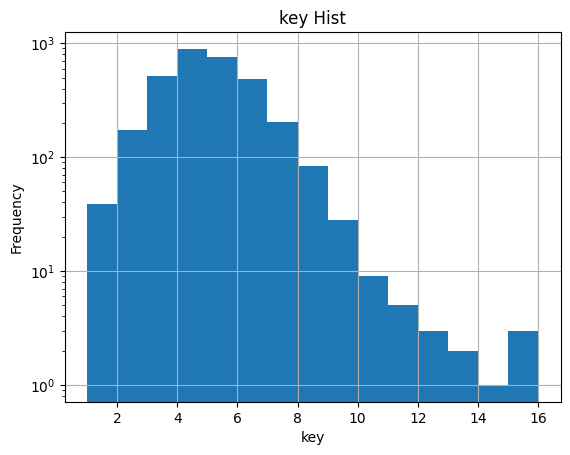

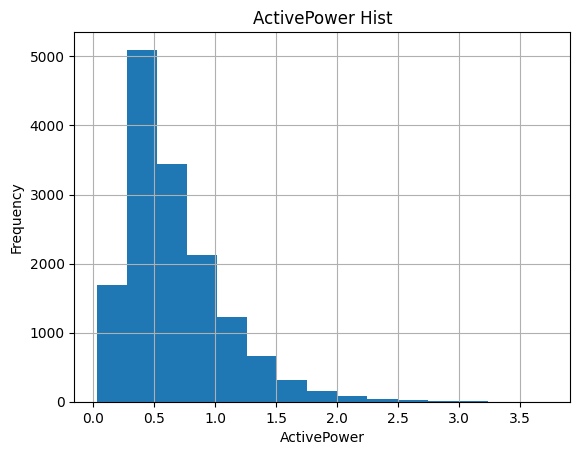

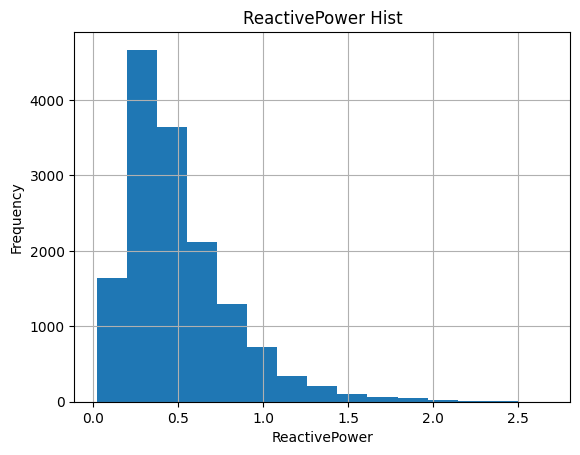

In [23]:
# посмотрим на структуру данных, насколько однообразны количества нагреваний

data_arc.groupby('key')['key'].count()\
           .plot(kind='hist', bins=15, grid=True)
plt.yscale('log')
plt.xlabel('key')
plt.title('key Hist')
plt.show()

data_arc['ActivePower']\
           .plot(kind='hist', bins=15, grid=True)
plt.xlabel('ActivePower')
plt.title('ActivePower Hist')
plt.show()

data_arc['ReactivePower']\
           .plot(kind='hist', bins=15, grid=True)
plt.xlabel('ReactivePower')
plt.title('ReactivePower Hist')
plt.show()

In [24]:
# по каждой партии нам необходимо иметь лишь одно наблюдение, поэтому,
# очевидно, надо будет воспользоваться методами аггрегирования
data_arc['heat_time'] = (data_arc['EndHeat'] - data_arc['BeginHeat']).astype('int')//10**9
data_arc['power_proportion'] = data_arc['ReactivePower']/data_arc['ActivePower']
display(data_arc.head())
display(data_arc.shape)

key           BeginHeat             EndHeat  ActivePower  ReactivePower  \
0    1 1900-01-01 11:02:14 1900-01-01 11:06:02     0.976059       0.687084   
1    1 1900-01-01 11:07:28 1900-01-01 11:10:33     0.805607       0.520285   
2    1 1900-01-01 11:11:44 1900-01-01 11:14:36     0.744363       0.498805   
3    1 1900-01-01 11:18:14 1900-01-01 11:24:19     1.659363       1.062669   
4    1 1900-01-01 11:26:09 1900-01-01 11:28:37     0.692755       0.414397   

   heat_time  power_proportion  
0        228          0.703937  
1        185          0.645830  
2        172          0.670110  
3        365          0.640408  
4        148          0.598188

(14876, 7)

In [25]:
features_data_arc = data_arc.groupby('key').agg({'key': ['count'],
                                     'ActivePower': [np.mean, np.median, np.sum],
                                     'ReactivePower': [np.mean, np.median, np.sum],
                                     'heat_time': [np.mean, np.median, np.sum],
                                     'power_proportion': [np.mean, np.median]})
features_data_arc.columns = ['_'.join(col) for col in features_data_arc.columns]

In [26]:
display(features_data_arc.head())
display(features_data_arc.tail())
display(features_data_arc.shape)

key_count  ActivePower_mean  ActivePower_median  ActivePower_sum  \
key                                                                     
1            5          0.975629            0.805607         4.878147   
2            4          0.763150            0.659060         3.052598   
3            5          0.505176            0.429355         2.525882   
4            4          0.802313            0.781301         3.209250   
5            4          0.836793            0.729026         3.347173   

     ReactivePower_mean  ReactivePower_median  ReactivePower_sum  \
key                                                                
1              0.636648              0.520285           3.183241   
2              0.499528              0.411077           1.998112   
3              0.319815              0.271774           1.599076   
4              0.515074              0.518548           2.060298   
5              0.563161              0.511438           2.252643   

     heat_time_mean  heat_time_median  heat_time_sum  power_proportion_mean  \
key                                                                           
1            219.60             185.0           1098               0.651695   
2            202.75             173.5            811               0.645465   
3            131.00             109.0            655               0.631751   
4            185.25             182.0            741               0.641443   
5            217.25             191.5            869               0.676904   

     power_proportion_median  
key                           
1                   0.645830  
2                   0.635281  
3                   0.632261  
4                   0.624417  
5                   0.667329

key_count  ActivePower_mean  ActivePower_median  ActivePower_sum  \
key                                                                      
3237          5          0.786493            0.801703         3.932467   
3238          3          0.702176            0.717559         2.106529   
3239          8          0.583344            0.500244         4.666754   
3240          5          0.596817            0.521811         2.984083   
3241          5          0.494289            0.533670         2.471447   

      ReactivePower_mean  ReactivePower_median  ReactivePower_sum  \
key                                                                 
3237            0.565692              0.554933           2.828459   
3238            0.560394              0.520623           1.681182   
3239            0.388952              0.360726           3.111617   
3240            0.496653              0.416994           2.483267   
3241            0.339240              0.354439           1.696199   

      heat_time_mean  heat_time_median  heat_time_sum  power_proportion_mean  \
key                                                                            
3237           181.8             177.0            909               0.724274   
3238           182.0             170.0            546               0.798540   
3239           152.0             139.0           1216               0.670644   
3240           167.8             150.0            839               0.814330   
3241           131.8             157.0            659               0.677660   

      power_proportion_median  
key                            
3237                 0.707761  
3238                 0.833921  
3239                 0.653488  
3240                 0.759716  
3241                 0.660500

(3214, 12)

###### steel.data_bulk

In [27]:
query = '''
SELECT *
FROM steel.data_bulk
'''

data_bulk = pd.read_sql_query(query, con=engine)
data_bulk.fillna(0, inplace=True)

In [28]:
display(data_bulk.head())
display(data_bulk.info())
display(data_bulk.describe())

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     0.0     0.0     0.0    43.0     0.0     0.0     0.0     0.0   
1    2     0.0     0.0     0.0    73.0     0.0     0.0     0.0     0.0   
2    3     0.0     0.0     0.0    34.0     0.0     0.0     0.0     0.0   
3    4     0.0     0.0     0.0    81.0     0.0     0.0     0.0     0.0   
4    5     0.0     0.0     0.0    78.0     0.0     0.0     0.0     0.0   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     0.0      0.0      0.0    206.0      0.0    150.0    154.0  
1     0.0      0.0      0.0    206.0      0.0    149.0    154.0  
2     0.0      0.0      0.0    205.0      0.0    152.0    153.0  
3     0.0      0.0      0.0    207.0      0.0    153.0    154.0  
4     0.0      0.0      0.0    203.0      0.0    151.0    152.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   3129 non-null   float64
 2   Bulk 2   3129 non-null   float64
 3   Bulk 3   3129 non-null   float64
 4   Bulk 4   3129 non-null   float64
 5   Bulk 5   3129 non-null   float64
 6   Bulk 6   3129 non-null   float64
 7   Bulk 7   3129 non-null   float64
 8   Bulk 8   3129 non-null   float64
 9   Bulk 9   3129 non-null   float64
 10  Bulk 10  3129 non-null   float64
 11  Bulk 11  3129 non-null   float64
 12  Bulk 12  3129 non-null   float64
 13  Bulk 13  3129 non-null   float64
 14  Bulk 14  3129 non-null   float64
 15  Bulk 15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

key       Bulk 1       Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  3129.000000  3129.000000  3129.000000  3129.000000   
mean   1624.383509     3.160435     1.779163    47.240332    33.830617   
std     933.337642    11.869164    21.217878    74.239954    56.034505   
min       1.000000     0.000000     0.000000     0.000000     0.000000   
25%     816.000000     0.000000     0.000000     0.000000     0.000000   
50%    1622.000000     0.000000     0.000000     0.000000     0.000000   
75%    2431.000000     0.000000     0.000000    80.000000    68.000000   
max    3241.000000   185.000000   325.000000   454.000000   281.000000   

            Bulk 5       Bulk 6       Bulk 7       Bulk 8       Bulk 9  \
count  3129.000000  3129.000000  3129.000000  3129.000000  3129.000000   
mean      2.633749    21.892298     2.441675     0.015660     0.463407   
std      20.918138    55.492582    31.944063     0.875978     6.154398   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max     603.000000   503.000000   772.000000    49.000000   147.000000   

           Bulk 10      Bulk 11      Bulk 12      Bulk 13      Bulk 14  \
count  3129.000000  3129.000000  3129.000000  3129.000000  3129.000000   
mean      4.684564     4.345478   203.948226     1.041866   152.706616   
std      20.157323    22.699580   151.419639    14.114252    81.091421   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000   105.000000     0.000000   104.000000   
50%       0.000000     0.000000   206.000000     0.000000   148.000000   
75%       0.000000     0.000000   263.000000     0.000000   202.000000   
max     159.000000   313.000000  1849.000000   305.000000   636.000000   

           Bulk 15  
count  3129.000000  
mean    115.319271  
std      84.488698  
min       0.000000  
25%       0.000000  
50%     106.000000  
75%     204.000000  
max     405.000000

In [29]:
# проверим на неочевидные неточности в данных
# быили ли партии без материалов
(data_bulk.sum(axis=1) == 0).sum()

0

In [30]:
features_data_bulk = data_bulk

display(features_data_bulk.head())
display(features_data_bulk.tail())
display(features_data_bulk.shape)

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     0.0     0.0     0.0    43.0     0.0     0.0     0.0     0.0   
1    2     0.0     0.0     0.0    73.0     0.0     0.0     0.0     0.0   
2    3     0.0     0.0     0.0    34.0     0.0     0.0     0.0     0.0   
3    4     0.0     0.0     0.0    81.0     0.0     0.0     0.0     0.0   
4    5     0.0     0.0     0.0    78.0     0.0     0.0     0.0     0.0   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     0.0      0.0      0.0    206.0      0.0    150.0    154.0  
1     0.0      0.0      0.0    206.0      0.0    149.0    154.0  
2     0.0      0.0      0.0    205.0      0.0    152.0    153.0  
3     0.0      0.0      0.0    207.0      0.0    153.0    154.0  
4     0.0      0.0      0.0    203.0      0.0    151.0    152.0

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
3124  3237     0.0     0.0   170.0     0.0     0.0     0.0     0.0     0.0   
3125  3238     0.0     0.0   126.0     0.0     0.0     0.0     0.0     0.0   
3126  3239     0.0     0.0     0.0     0.0     0.0   114.0     0.0     0.0   
3127  3240     0.0     0.0     0.0     0.0     0.0    26.0     0.0     0.0   
3128  3241     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

      Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
3124     0.0      0.0      0.0    252.0      0.0    130.0    206.0  
3125     0.0      0.0      0.0    254.0      0.0    108.0    106.0  
3126     0.0      0.0      0.0    158.0      0.0    270.0     88.0  
3127     0.0      0.0      0.0      0.0      0.0    192.0     54.0  
3128     0.0      0.0      0.0      0.0      0.0    180.0     52.0

(3129, 16)

###### steel.data_bulk_time

In [31]:
query = '''
SELECT *
FROM steel.data_bulk_time
'''

data_bulk_time = pd.read_sql_query(query, con=engine)
data_bulk_time.set_index('key', inplace=True)
data_bulk_time.replace({None:np.nan}, inplace=True)

In [32]:
# проверим формат представленных дат на соответствие
try:
    data_bulk_time = pd.to_datetime(data_bulk_time.stack().dropna(), format='%H:%M:%S', errors='raise')
except:
    print('format problem')

In [33]:
data_bulk_time = (data_bulk_time.astype('int')/10**9+2208900000).unstack()
data_bulk_time.fillna(0, inplace=True)
data_bulk_time.reset_index(inplace=True)

In [34]:
features_data_bulk_time = data_bulk_time

display(features_data_bulk_time.head())
display(features_data_bulk_time.tail())
display(features_data_bulk_time.shape)

key  Bulk 1  Bulk 2  Bulk 3   Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     0.0     0.0     0.0 -47910.0     0.0     0.0     0.0     0.0   
1    2     0.0     0.0     0.0 -46402.0     0.0     0.0     0.0     0.0   
2    3     0.0     0.0     0.0 -43734.0     0.0     0.0     0.0     0.0   
3    4     0.0     0.0     0.0 -42677.0     0.0     0.0     0.0     0.0   
4    5     0.0     0.0     0.0 -40870.0     0.0     0.0     0.0     0.0   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     0.0      0.0      0.0 -48968.0      0.0 -48968.0 -48968.0  
1     0.0      0.0      0.0 -46780.0      0.0 -46780.0 -46780.0  
2     0.0      0.0      0.0 -45020.0      0.0 -45020.0 -45020.0  
3     0.0      0.0      0.0 -43116.0      0.0 -43116.0 -43116.0  
4     0.0      0.0      0.0 -41224.0      0.0 -41224.0 -41224.0

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5   Bulk 6  Bulk 7  Bulk 8  \
3124  3237     0.0     0.0 -6512.0     0.0     0.0      0.0     0.0     0.0   
3125  3238     0.0     0.0 -3649.0     0.0     0.0      0.0     0.0     0.0   
3126  3239     0.0     0.0     0.0     0.0     0.0 -82082.0     0.0     0.0   
3127  3240     0.0     0.0     0.0     0.0     0.0 -77240.0     0.0     0.0   
3128  3241     0.0     0.0     0.0     0.0     0.0      0.0     0.0     0.0   

      Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
3124     0.0      0.0      0.0  -6788.0      0.0  -6788.0  -6788.0  
3125     0.0      0.0      0.0  -4011.0      0.0  -4011.0  -4011.0  
3126     0.0      0.0      0.0 -82819.0      0.0 -83195.0 -83195.0  
3127     0.0      0.0      0.0      0.0      0.0 -79113.0 -79113.0  
3128     0.0      0.0      0.0      0.0      0.0 -74066.0 -74066.0

(3129, 16)

###### steel.data_gas

In [35]:
query = '''
SELECT *
FROM steel.data_gas
'''

data_gas = pd.read_sql_query(query, con=engine)

In [36]:
display(data_gas.head())
display(data_gas.info())
display(data_gas.shape)

key        gas
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

(3239, 2)

In [37]:
features_data_gas = data_gas

display(data_gas.head())
display(data_gas.tail())
display(data_gas.shape)

key        gas
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

key        gas
3234  3237   5.543905
3235  3238   6.745669
3236  3239  16.023518
3237  3240  11.863103
3238  3241  12.680959

(3239, 2)

###### steel.data_wire

In [38]:
query = '''
SELECT *
FROM steel.data_wire
'''

data_wire = pd.read_sql_query(query, con=engine)

In [39]:
display(data_wire.head())
display(data_wire.info())
display(data_wire.shape)

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

(3081, 10)

In [40]:
data_wire.fillna(0, inplace=True)

# были партии без добавления материалов
(data_wire.sum(axis=1) == 0).sum()

0

In [41]:
features_data_wire = data_wire

display(features_data_wire.head())
display(features_data_wire.tail())
display(features_data_wire.shape)

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
1    2  96.052315  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
2    3  91.160157  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
3    4  89.063515  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
4    5  89.238236  9.11456     0.0     0.0     0.0     0.0     0.0     0.0   

   Wire 9  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0

key      Wire 1  Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  \
3076  3237   38.088959     0.0     0.0     0.0     0.0     0.0     0.0   
3077  3238   56.128799     0.0     0.0     0.0     0.0     0.0     0.0   
3078  3239  143.357761     0.0     0.0     0.0     0.0     0.0     0.0   
3079  3240   34.070400     0.0     0.0     0.0     0.0     0.0     0.0   
3080  3241   63.117595     0.0     0.0     0.0     0.0     0.0     0.0   

      Wire 8  Wire 9  
3076     0.0     0.0  
3077     0.0     0.0  
3078     0.0     0.0  
3079     0.0     0.0  
3080     0.0     0.0

(3081, 10)

###### steel.data_wire_time

In [42]:
query = '''
SELECT *
FROM steel.data_wire_time
'''

data_wire_time = pd.read_sql_query(query, con=engine)
data_wire_time.set_index('key', inplace=True)
data_wire_time.replace({None:np.nan}, inplace=True)

In [43]:
display(data_wire_time.head())
display(data_wire_time.info())
display(data_wire_time.describe())

Wire 1    Wire 2 Wire 3 Wire 4 Wire 5 Wire 6 Wire 7 Wire 8 Wire 9
key                                                                     
1    11:11:41       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
2    11:46:10       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
3    12:13:47       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
4    12:48:05       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
5    13:18:15  13:32:06    NaN    NaN    NaN    NaN    NaN    NaN    NaN

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Wire 1  3055 non-null   object
 1   Wire 2  1079 non-null   object
 2   Wire 3  63 non-null     object
 3   Wire 4  14 non-null     object
 4   Wire 5  1 non-null      object
 5   Wire 6  73 non-null     object
 6   Wire 7  11 non-null     object
 7   Wire 8  19 non-null     object
 8   Wire 9  29 non-null     object
dtypes: object(9)
memory usage: 240.7+ KB


None

Wire 1    Wire 2    Wire 3    Wire 4    Wire 5    Wire 6    Wire 7  \
count       3055      1079        63        14         1        73        11   
unique      3000      1075        63        14         1        73        11   
top     10:07:11  11:15:54  04:47:53  08:48:23  16:01:07  08:37:20  12:42:00   
freq           2         2         1         1         1         1         1   

          Wire 8    Wire 9  
count         19        29  
unique        19        29  
top     00:03:32  16:09:11  
freq           1         1

In [44]:
# проверим формат представленных дат на соответствие
try:
    data_wire_time = pd.to_datetime(data_wire_time.stack().dropna(), format='%H:%M:%S', errors='raise')
except:
    print('format problem')

In [45]:
data_wire_time = (data_wire_time.astype('int')/10**9+2208900000).unstack()
data_wire_time.fillna(0, inplace=True)
data_wire_time.reset_index(inplace=True)

In [46]:
features_data_wire_time = data_wire_time

display(features_data_wire_time.head())
display(features_data_wire_time.tail())
display(features_data_wire_time.shape)

key   Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1 -48499.0      0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1    2 -46430.0      0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2    3 -44773.0      0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3    4 -42715.0      0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4    5 -40905.0 -40074.0     0.0     0.0     0.0     0.0     0.0     0.0   

   Wire 9  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0

key   Wire 1  Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
3076  3237  -6580.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3077  3238  -3696.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3078  3239 -82157.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3079  3240 -77278.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3080  3241 -73439.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

      Wire 9  
3076     0.0  
3077     0.0  
3078     0.0  
3079     0.0  
3080     0.0

(3081, 10)

##### Merging and Sptitting

In [47]:
# дропаем строки, если для них не нашлось данных по материалам и примесям, чтобы не возникало ненужных скосов и баесов

features = features_data_temp.merge(target, how='left', left_on='key', right_index=True)\
                             .merge(features_data_arc, how='left', left_on='key', right_on='key')\
                             .merge(features_data_bulk, how='left', left_on='key', right_on='key')\
                             .merge(features_data_bulk_time, how='left', left_on='key', right_on='key')\
                             .merge(features_data_gas, how='left', left_on='key', right_on='key')\
                             .merge(features_data_wire, how='left', left_on='key', right_on='key')\
                             .merge(features_data_wire_time, how='left', left_on='key', right_on='key')\
                             .dropna()\
                             .drop('key', axis=1)

In [48]:
hue = pd.qcut(features['target'], 5, labels=False)
hue.name = 'hue'

In [49]:
pp = pd.concat([features.iloc[:, :14], hue], axis=1)

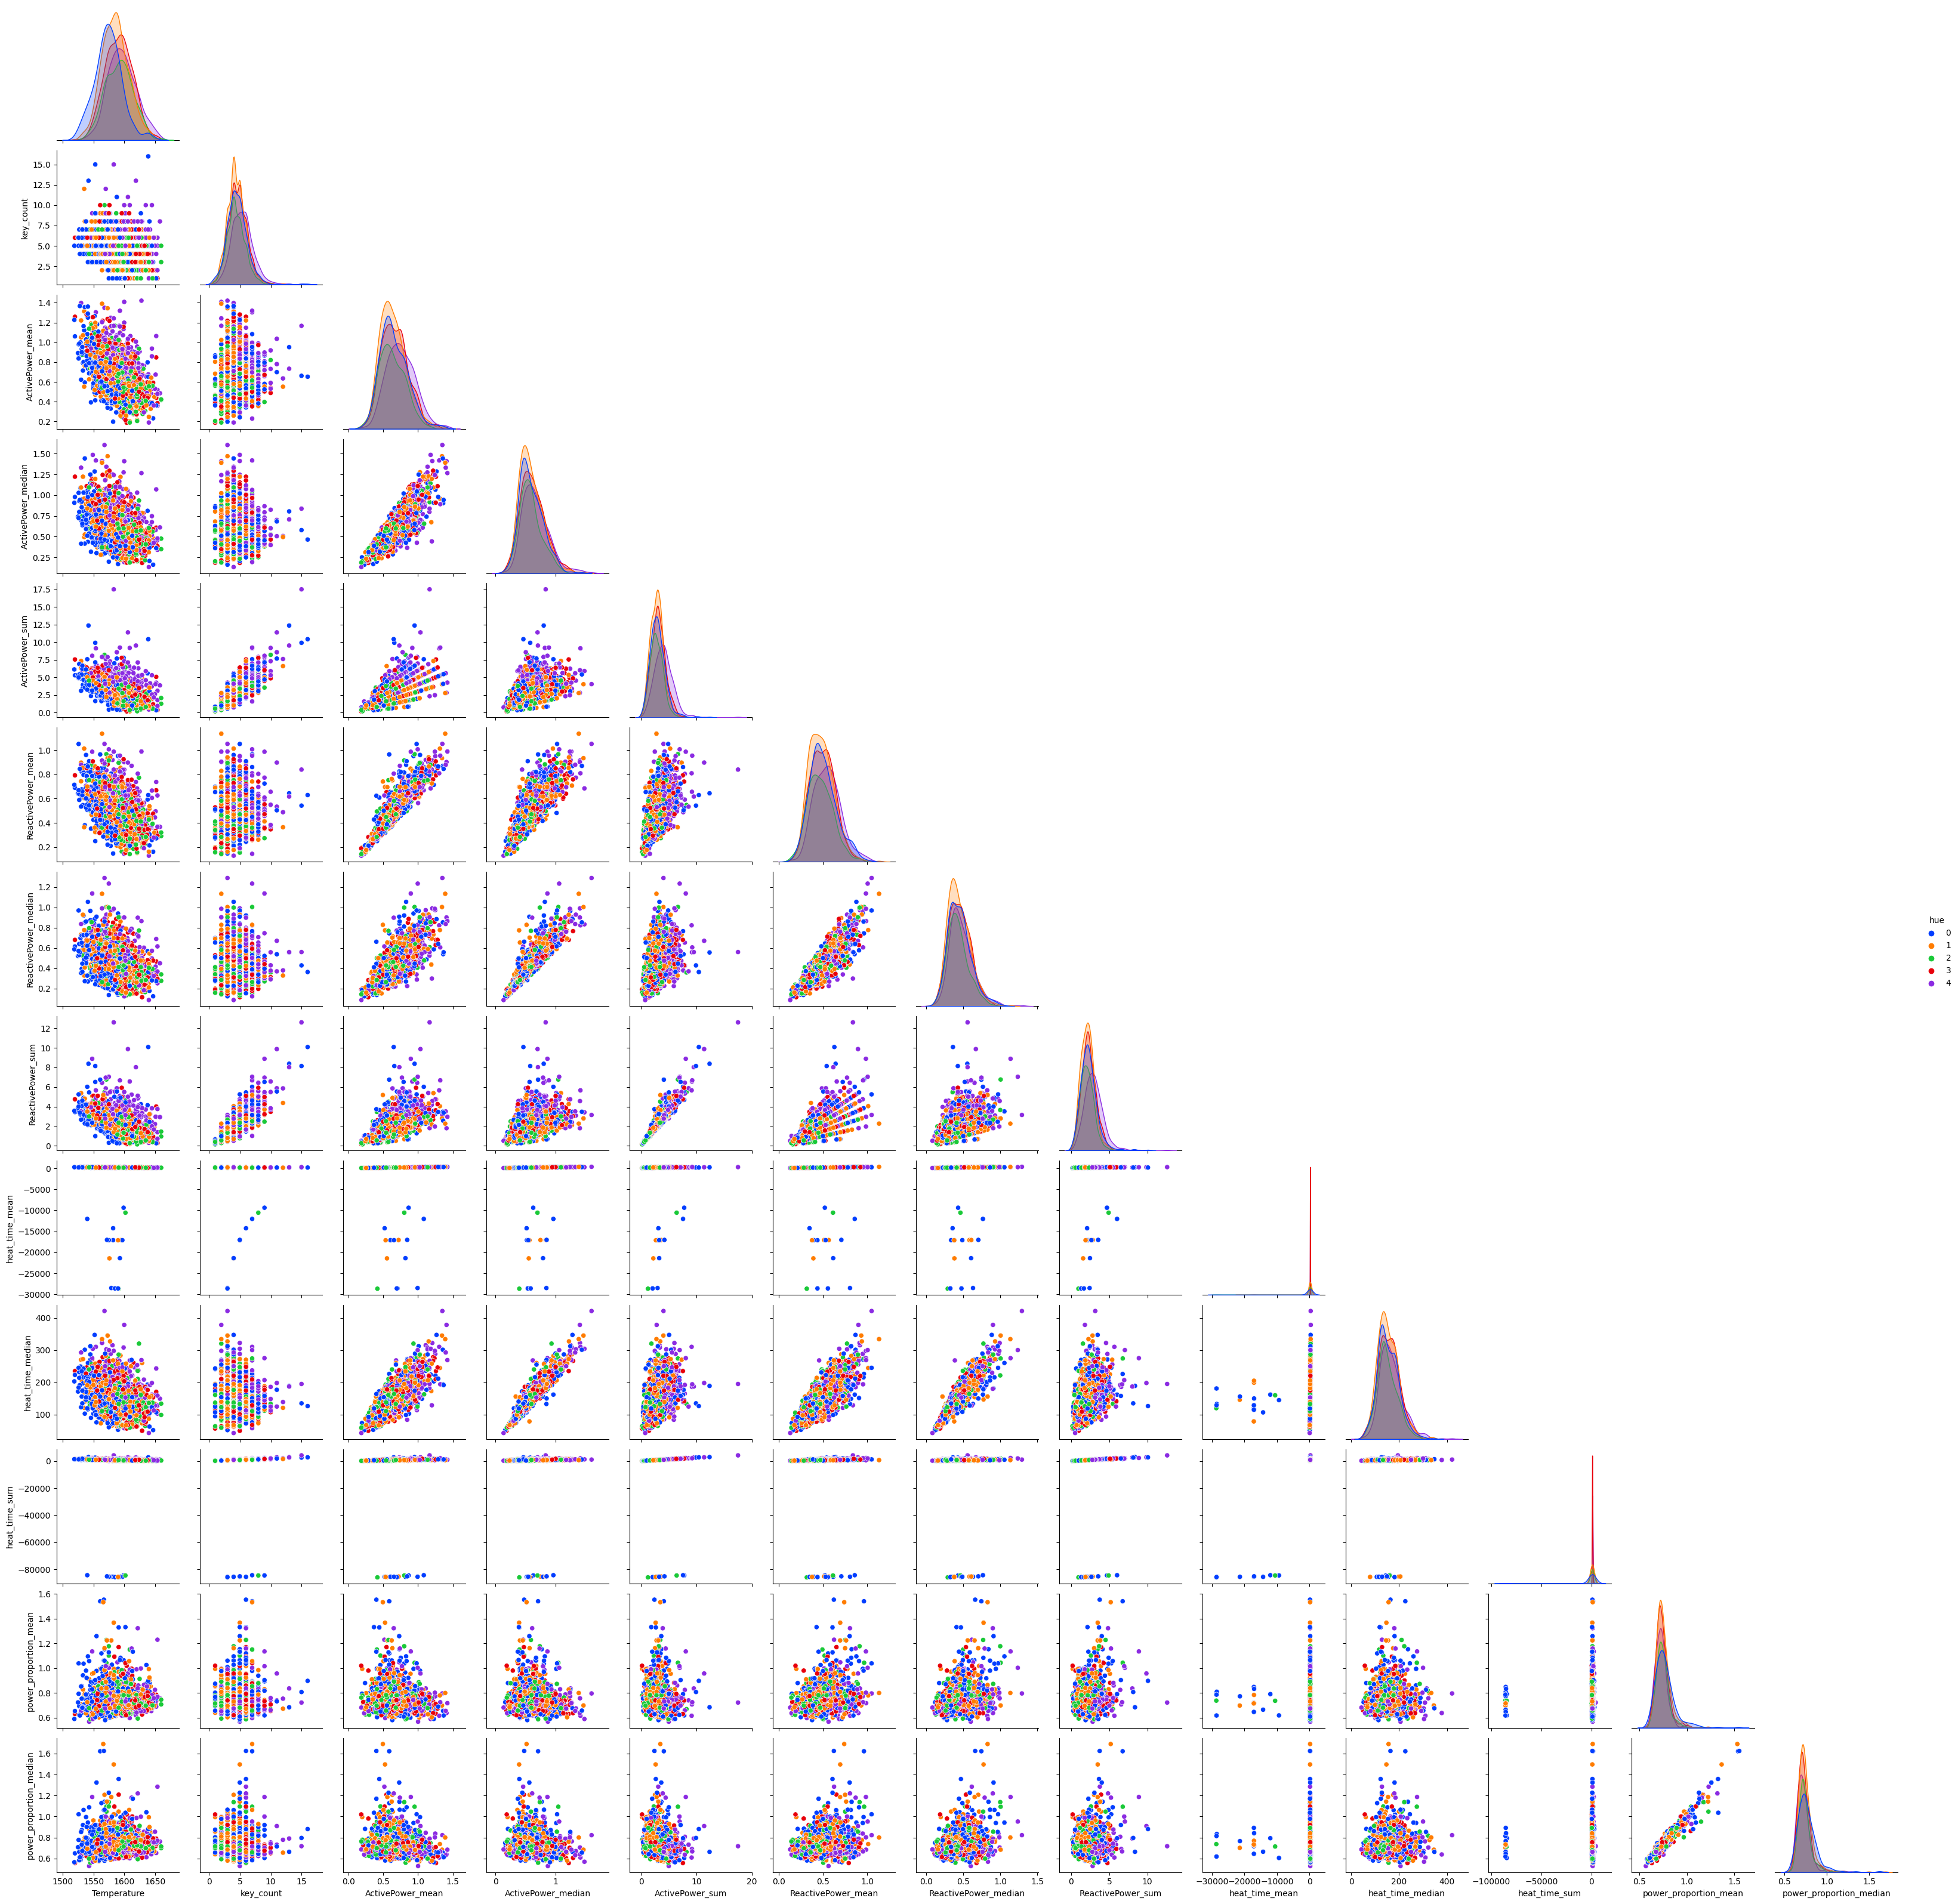

In [50]:
sns.pairplot(pp.drop('target', axis=1),
             corner=True,
             hue='hue',
             palette='bright'
            )

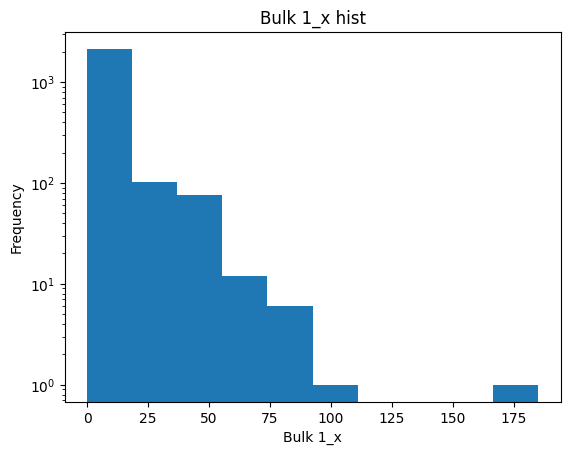

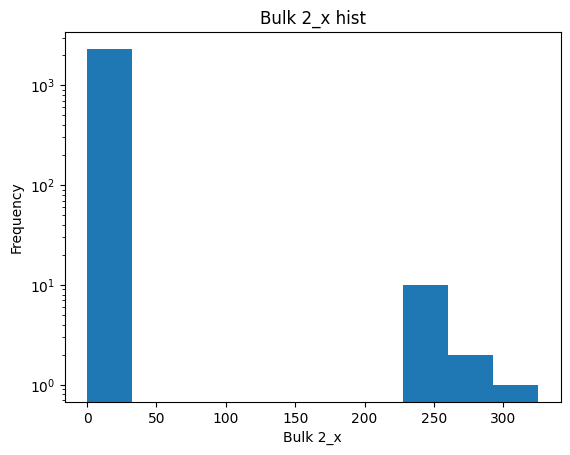

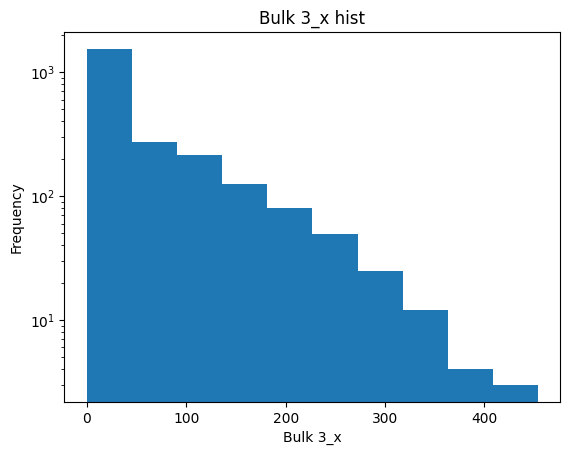

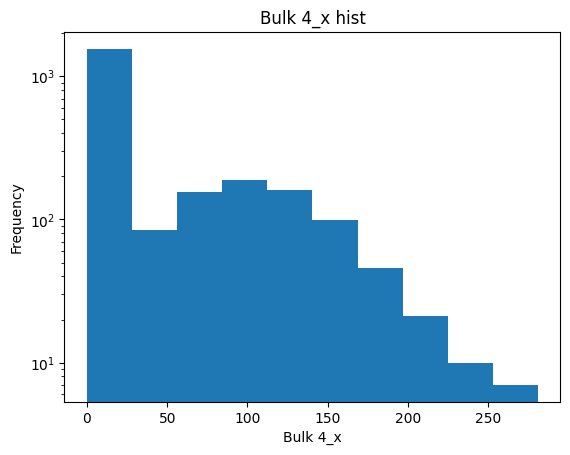

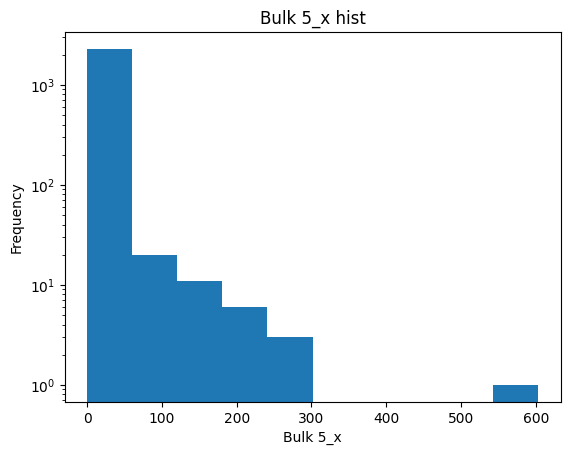

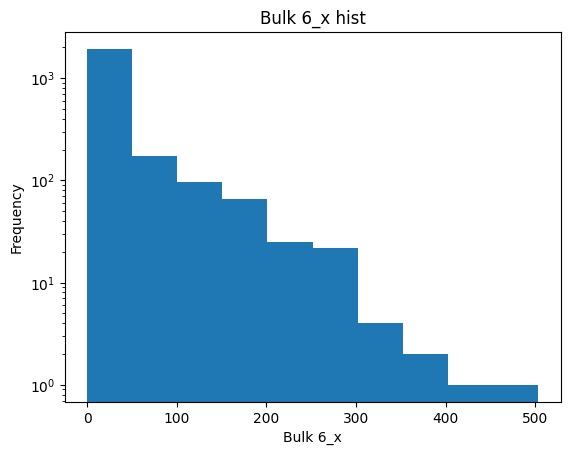

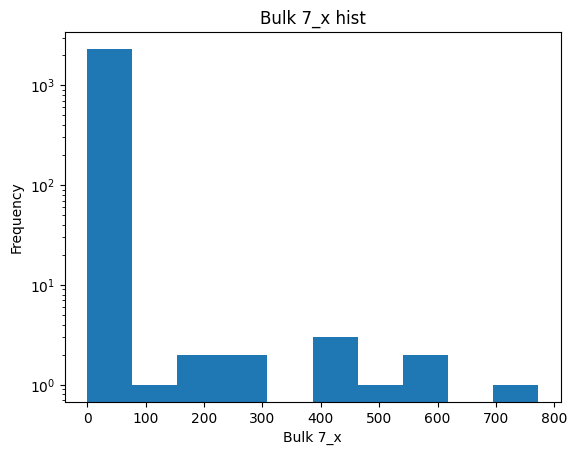

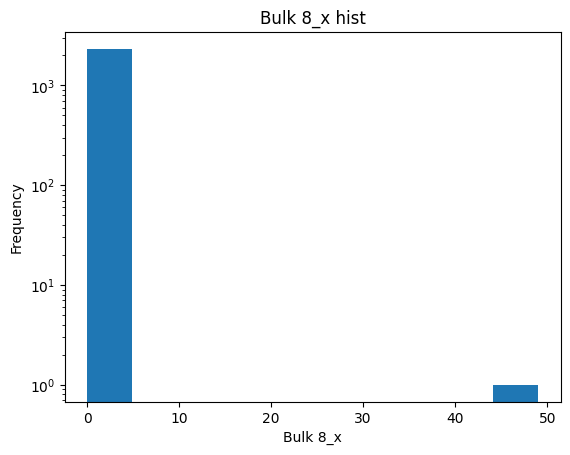

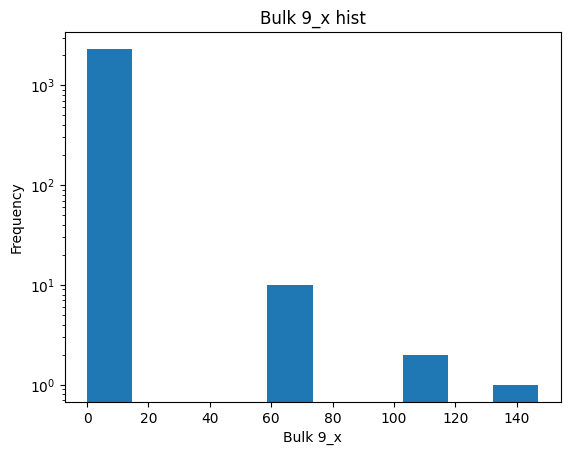

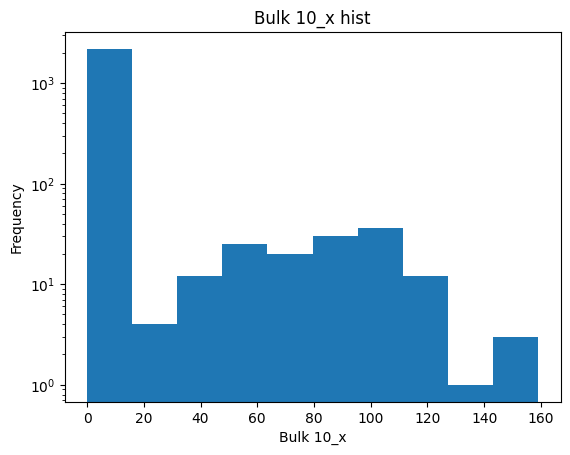

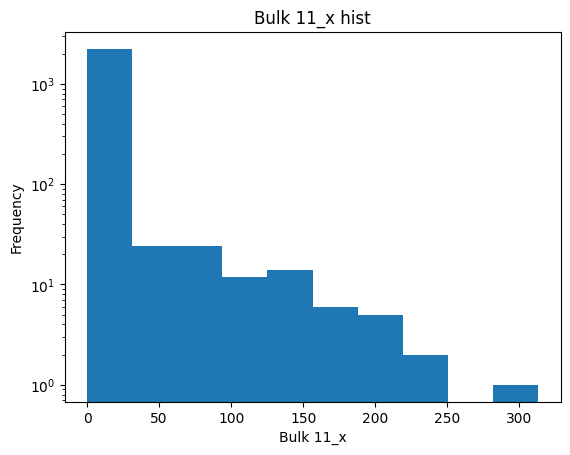

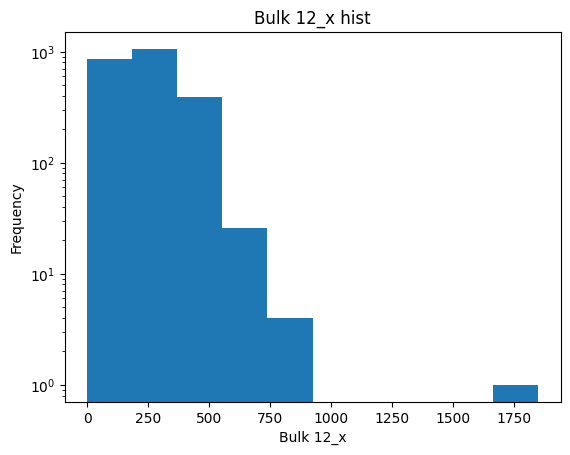

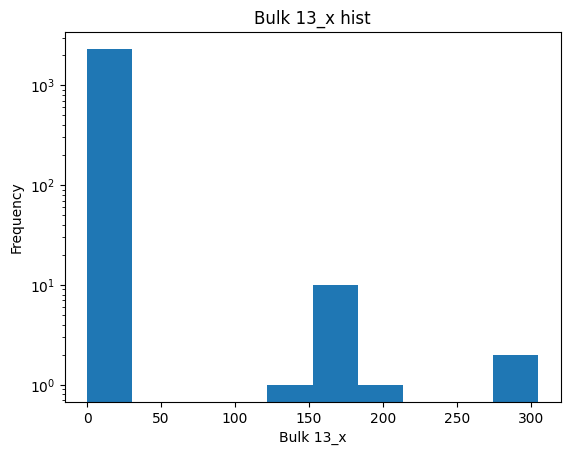

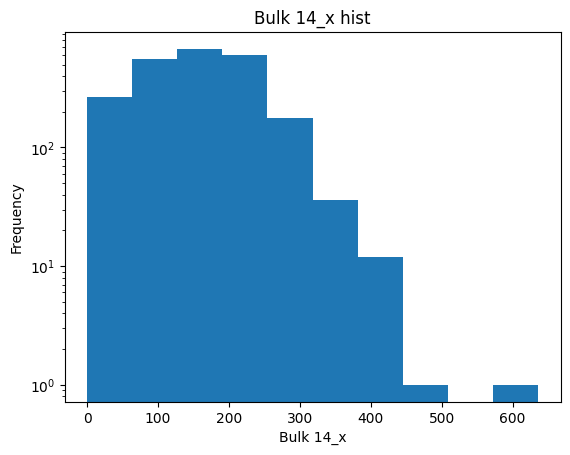

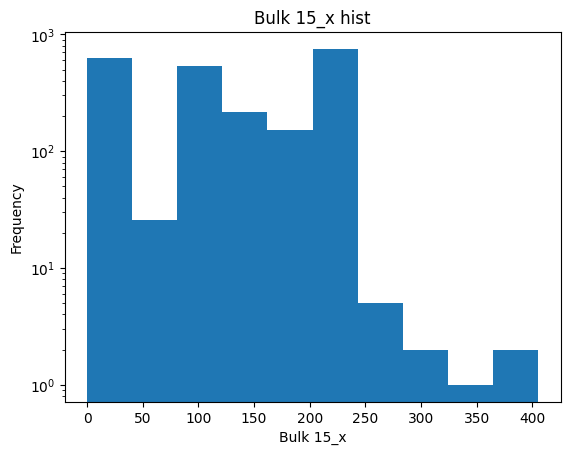

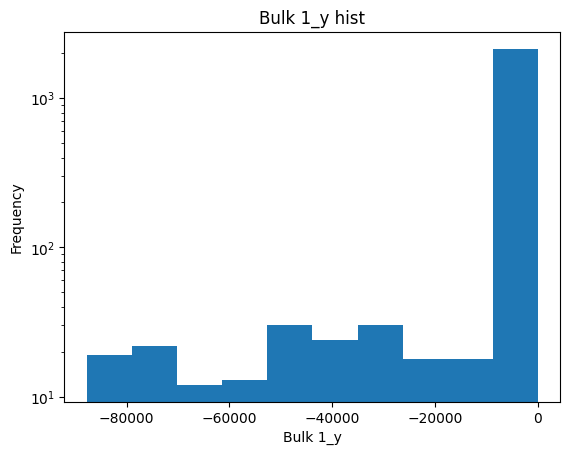

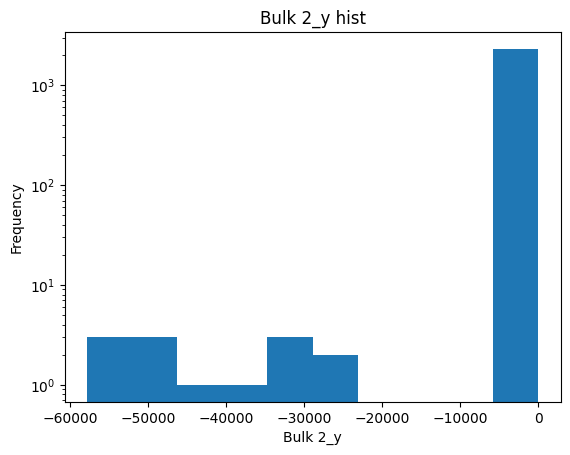

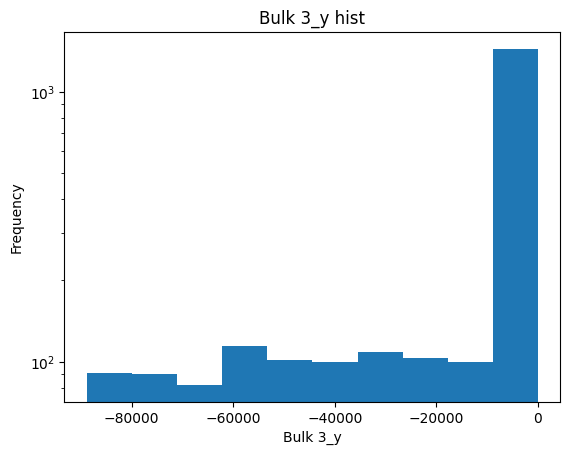

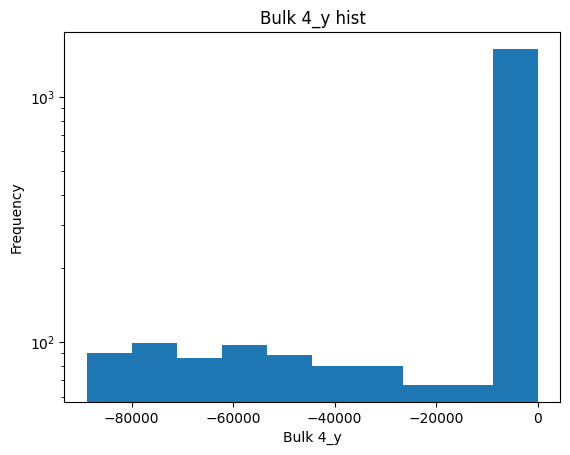

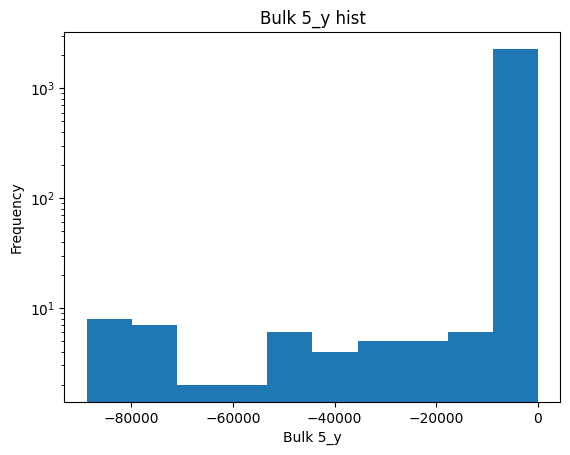

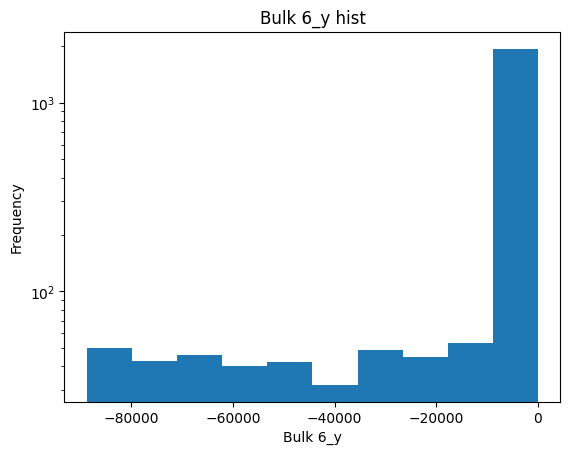

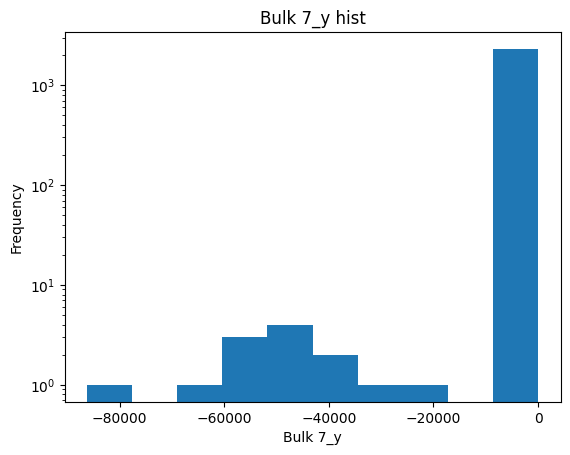

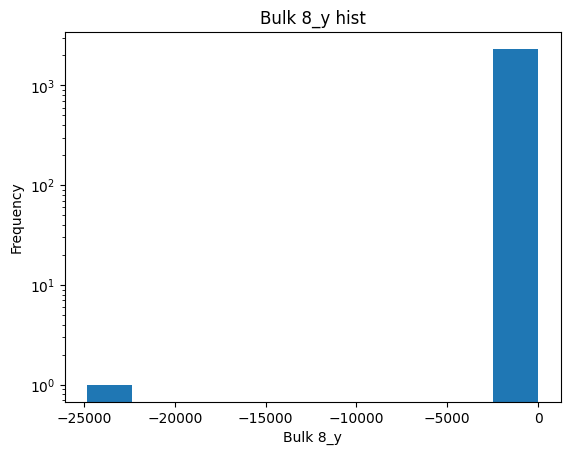

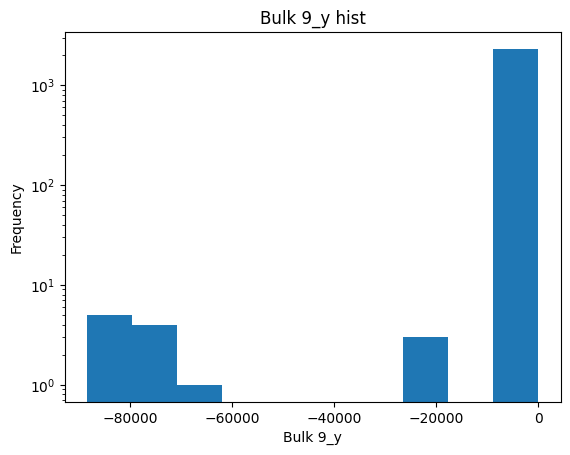

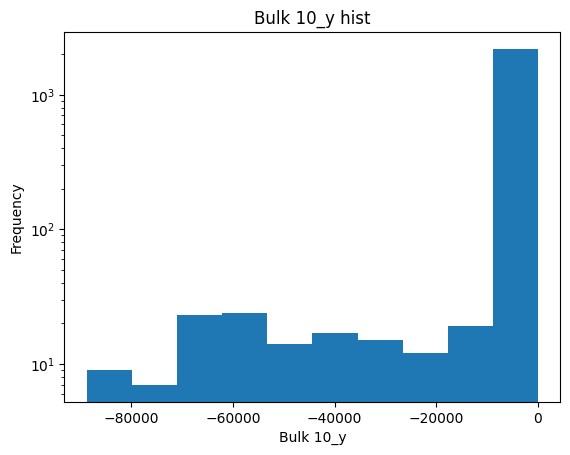

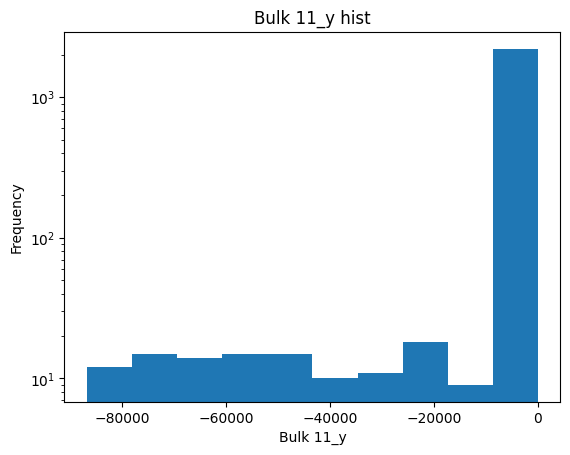

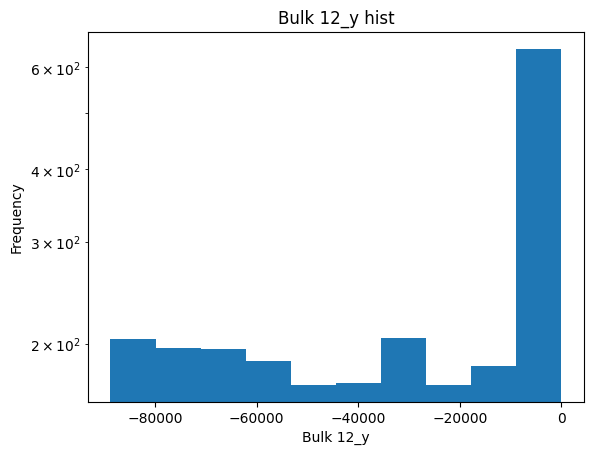

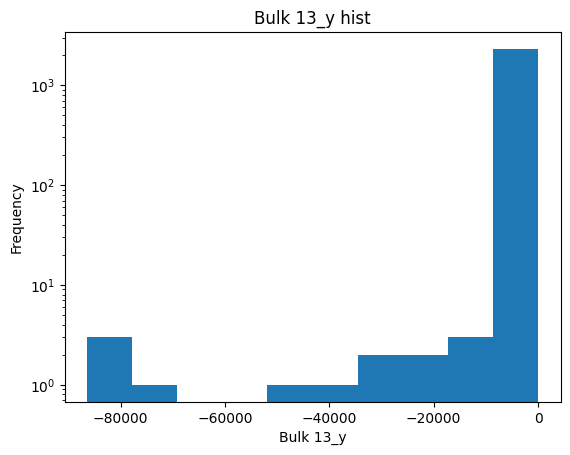

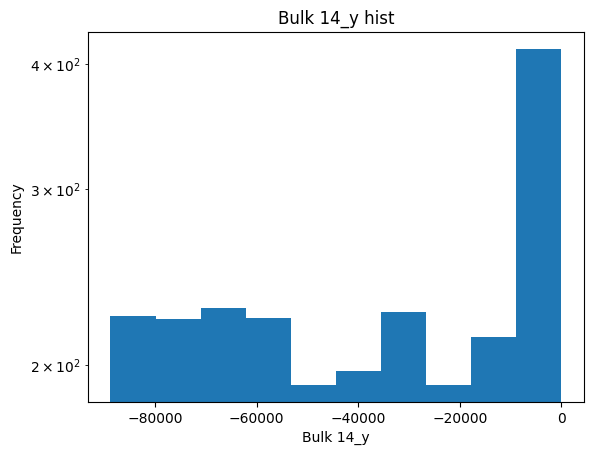

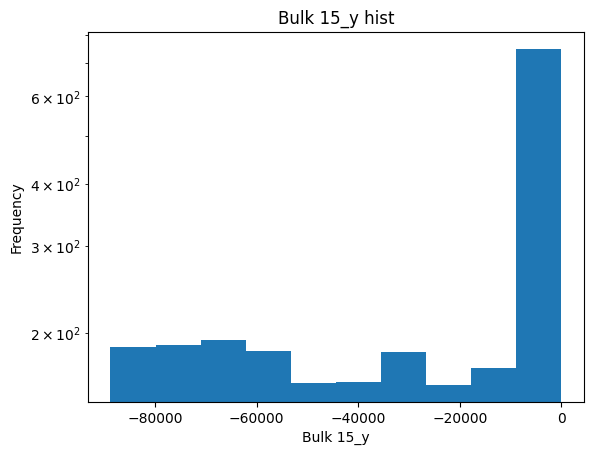

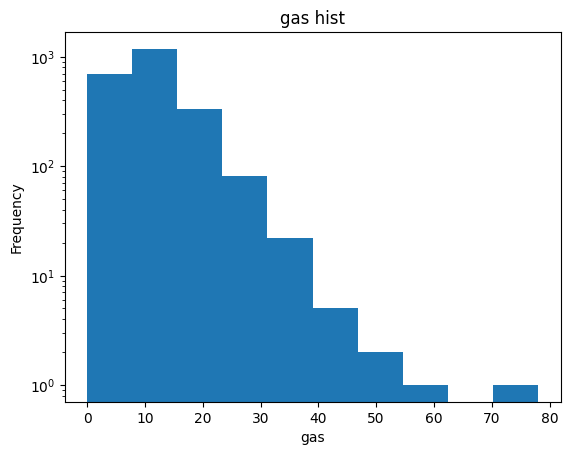

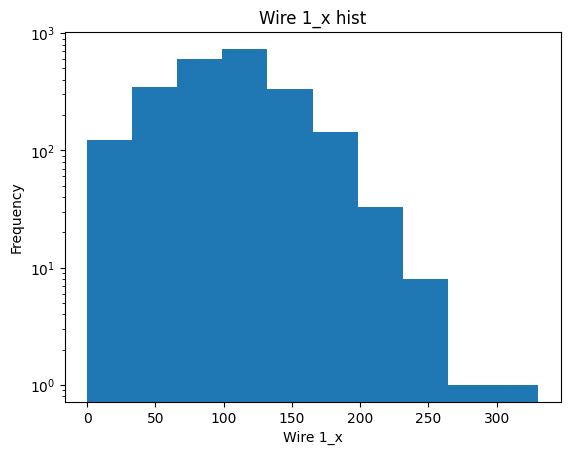

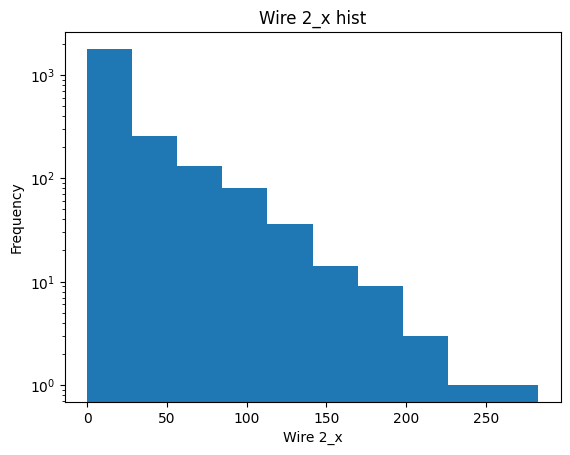

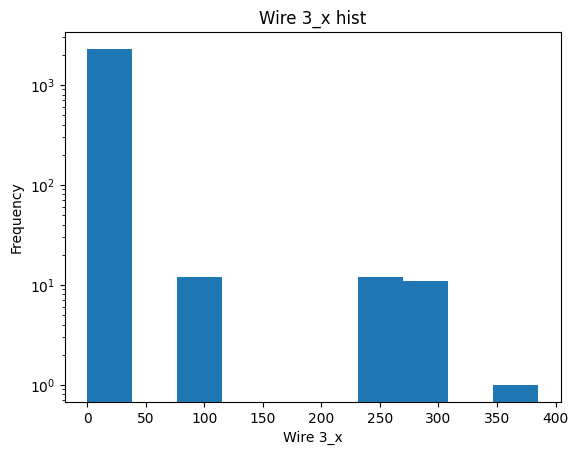

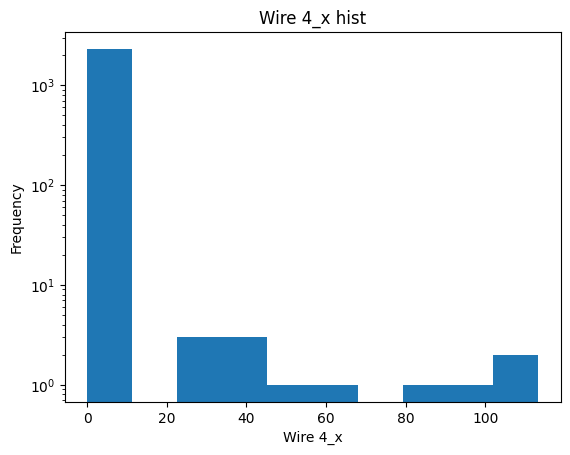

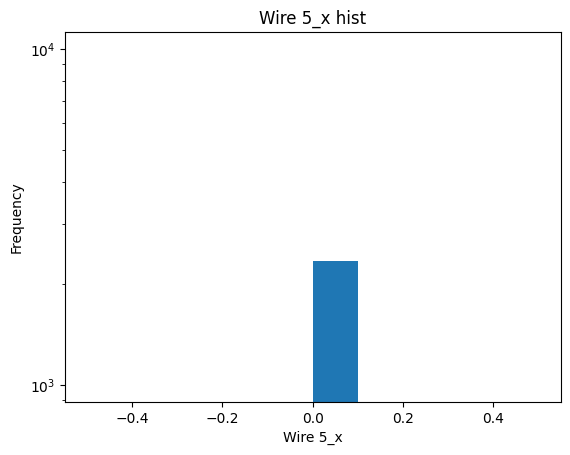

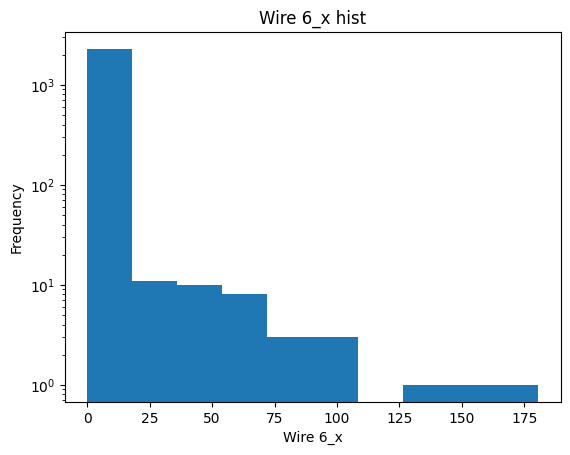

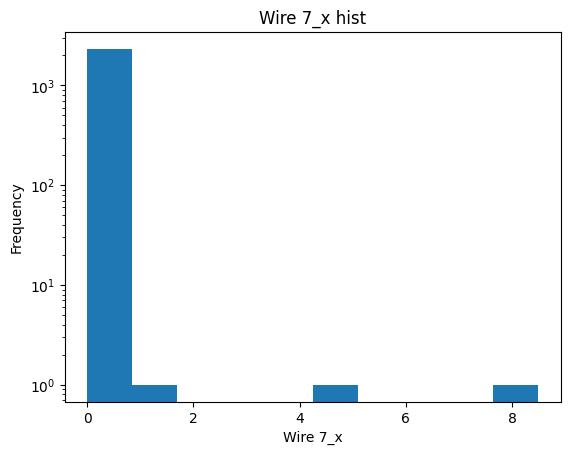

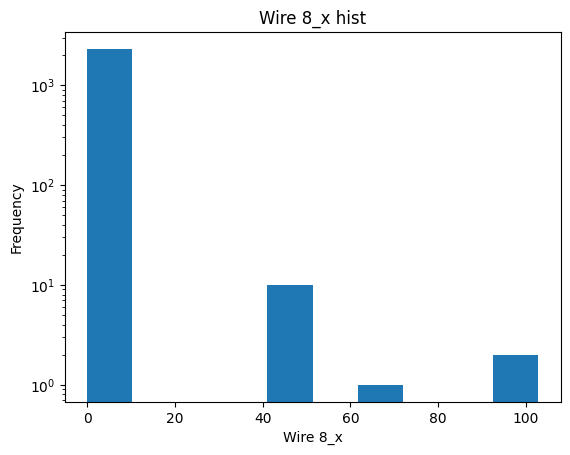

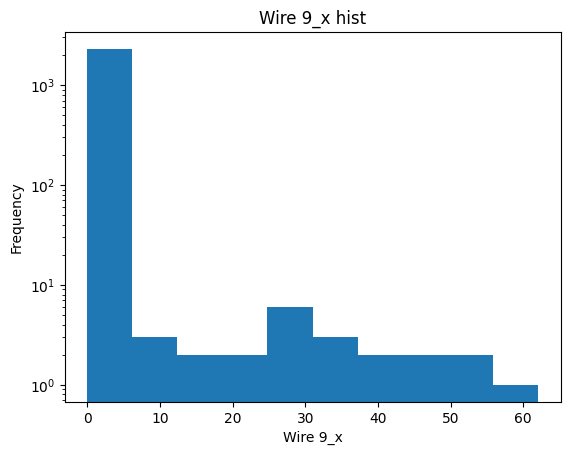

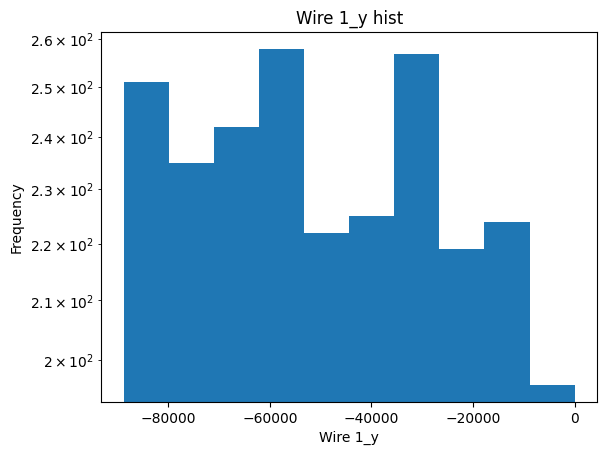

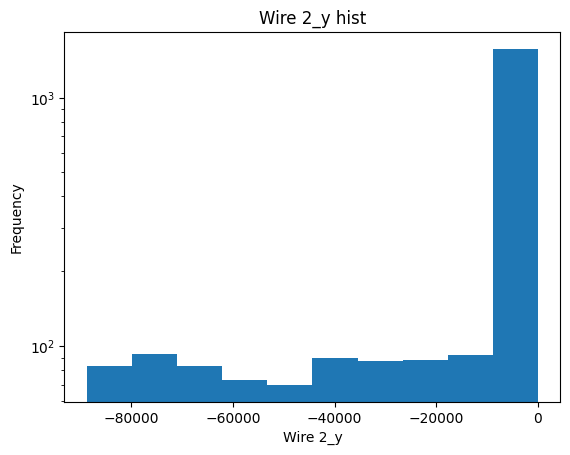

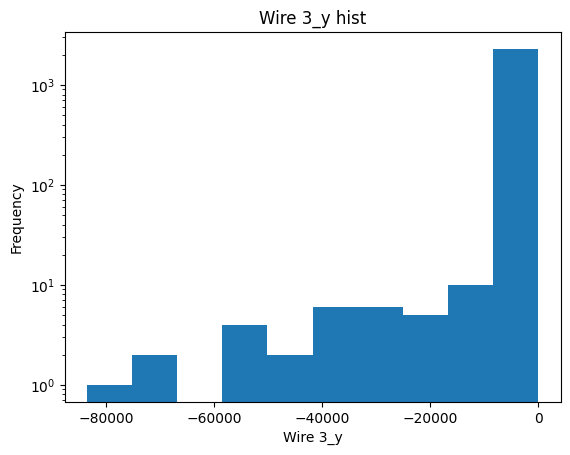

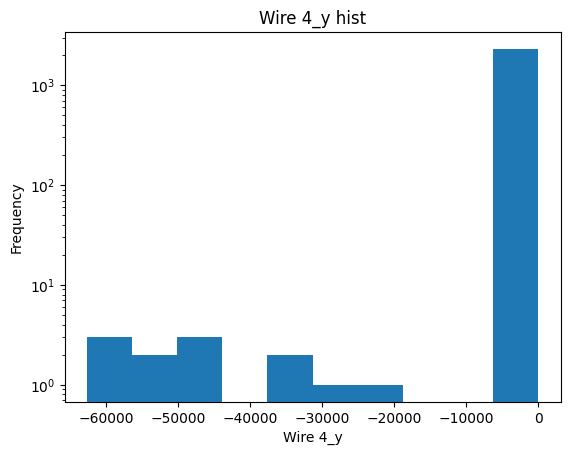

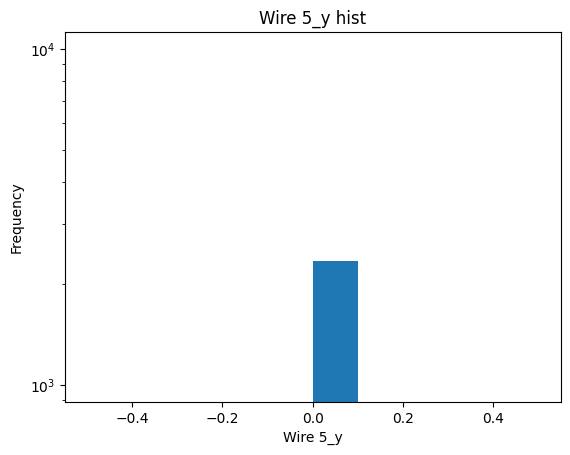

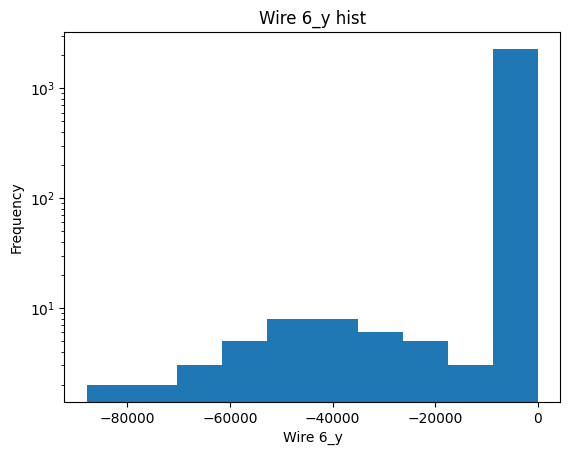

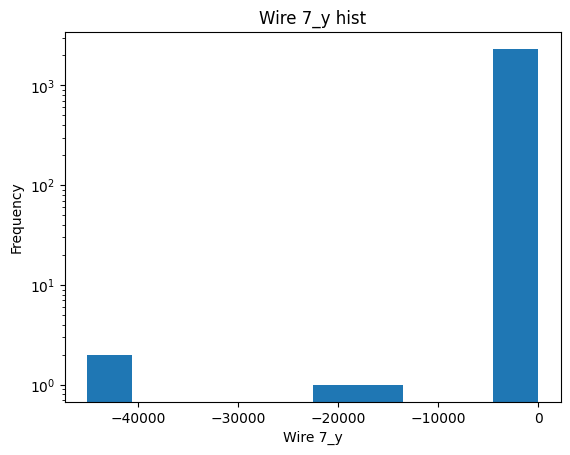

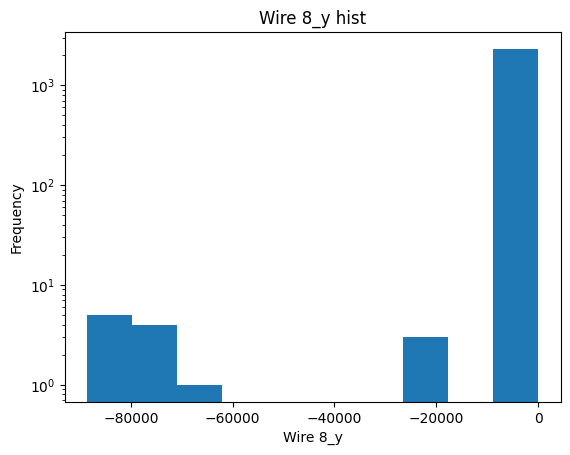

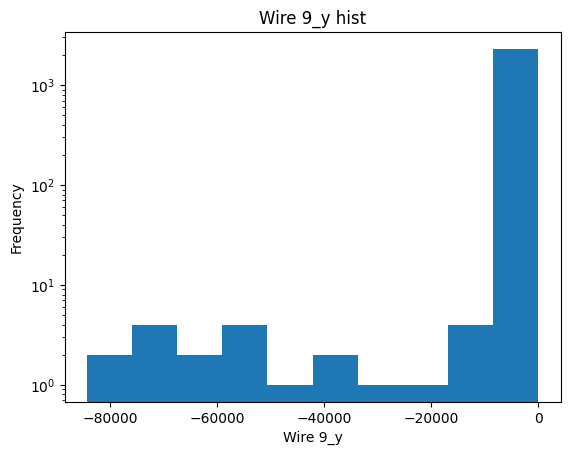

In [51]:
for col in features.columns[14:]:
    features[col].plot(kind='hist')
    plt.yscale('log')
    plt.xlabel(col)
    plt.title(col+' hist')
    plt.show()

<AxesSubplot: >

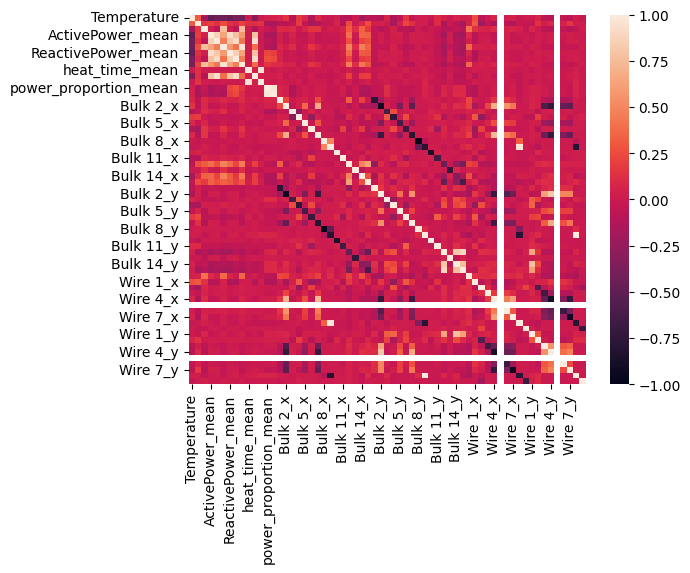

In [52]:
sns.heatmap(features.corr())

Как мы можем заметить из попарной таблицы - признаков, которые самостоятельно бы идельно коррелировали бы с целевой переменной, у нас нет. Так же мы можем заметить, что признаков, которые бы это делали попарно также нет, по крайне мере в таблице data_arc. Что касается данных по сыпучим и проволочным материалам, а также газам - то, очевидно, что большинство значений равны нулю (не были представлены), и распределены ассиметрично.

In [53]:
features, target = features.drop('target', axis=1), features['target']
display(features.shape)
display(target.shape)

(2329, 62)

(2329,)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE)

#### Шаг 3. Обучение модели

##### Dummy модель

In [55]:
dummy_model = DummyRegressor(strategy='median')
dummy_model.fit(X_train, y_train)
mean_absolute_error(y_test, dummy_model.predict(X_test))

8.030874785591767

##### Древесные модели

In [56]:
model_types = {
               'rf': RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
               'lgb': LGBMRegressor(n_jobs=-1)
              }

models_params = {
                 'rf': {'max_depth': np.arange(16, 64+1, 16),
                        'n_estimators': [100, 200, 300],
                        'criterion': ['squared_error', 'absolute_error']},
                 'lgb': {'max_depth': np.arange(8, 64+1, 8),
                         'objective': ['regression', 'poisson', 'mape', 'fair'],
                        }
                }


In [57]:
%%time
best_models = {}
cv_results = {}

for model_type in model_types:
    model = model_types[model_type]
    grid = GridSearchCV(model, models_params[model_type],
                        cv=5,
                        scoring=['neg_mean_absolute_error', 'r2'],
                        n_jobs=1, refit='neg_mean_absolute_error',
                        return_train_score=False)
    
    grid.fit(X_train, y_train)
    best_models[model_type] = grid.best_estimator_
    cv_results[model_type] = grid.cv_results_
    print('Лучшая модель в группе {} имеет значение -mae равное {:.2f} и параметры {}'\
          .format(model_type,\
                  grid.best_score_,\
                  grid.best_params_))
    print()

Лучшая модель в группе rf имеет значение -mae равное -6.22 и параметры {'criterion': 'squared_error', 'max_depth': 16, 'n_estimators': 300}

Лучшая модель в группе lgb имеет значение -mae равное -6.10 и параметры {'max_depth': 24, 'objective': 'mape'}

CPU times: user 17min 7s, sys: 10.8 s, total: 17min 18s
Wall time: 6min 25s


In [58]:
for model_type in cv_results:
    print(model_type)
    display(pd.DataFrame(cv_results[model_type])[['params',
                                                  'mean_test_neg_mean_absolute_error',
                                                  'mean_test_r2',
                                                  'rank_test_neg_mean_absolute_error']].sort_values('rank_test_neg_mean_absolute_error')\
                                                                                       .head(10)            
           )

rf


params  \
2   {'criterion': 'squared_error', 'max_depth': 16...   
1   {'criterion': 'squared_error', 'max_depth': 16...   
10  {'criterion': 'squared_error', 'max_depth': 64...   
7   {'criterion': 'squared_error', 'max_depth': 48...   
4   {'criterion': 'squared_error', 'max_depth': 32...   
11  {'criterion': 'squared_error', 'max_depth': 64...   
8   {'criterion': 'squared_error', 'max_depth': 48...   
5   {'criterion': 'squared_error', 'max_depth': 32...   
0   {'criterion': 'squared_error', 'max_depth': 16...   
3   {'criterion': 'squared_error', 'max_depth': 32...   

    mean_test_neg_mean_absolute_error  mean_test_r2  \
2                           -6.224886      0.418837   
1                           -6.226942      0.418177   
10                          -6.236246      0.415291   
7                           -6.236246      0.415291   
4                           -6.236274      0.415284   
11                          -6.244308      0.415465   
8                           -6.244308      0.415465   
5                           -6.244595      0.415449   
0                           -6.245460      0.414308   
3                           -6.264876      0.407850   

    rank_test_neg_mean_absolute_error  
2                                   1  
1                                   2  
10                                  3  
7                                   3  
4                                   5  
11                                  6  
8                                   6  
5                                   8  
0                                   9  
3                                  10

lgb


params  \
26     {'max_depth': 56, 'objective': 'mape'}   
22     {'max_depth': 48, 'objective': 'mape'}   
18     {'max_depth': 40, 'objective': 'mape'}   
30     {'max_depth': 64, 'objective': 'mape'}   
10     {'max_depth': 24, 'objective': 'mape'}   
14     {'max_depth': 32, 'objective': 'mape'}   
6      {'max_depth': 16, 'objective': 'mape'}   
2       {'max_depth': 8, 'objective': 'mape'}   
1    {'max_depth': 8, 'objective': 'poisson'}   
5   {'max_depth': 16, 'objective': 'poisson'}   

    mean_test_neg_mean_absolute_error  mean_test_r2  \
26                          -6.101286      0.420879   
22                          -6.101286      0.420879   
18                          -6.101286      0.420879   
30                          -6.101286      0.420879   
10                          -6.101286      0.420879   
14                          -6.101286      0.420879   
6                           -6.135934      0.417245   
2                           -6.144042      0.412068   
1                           -6.172842      0.418950   
5                           -6.190276      0.413447   

    rank_test_neg_mean_absolute_error  
26                                  1  
22                                  1  
18                                  1  
30                                  1  
10                                  1  
14                                  1  
6                                   7  
2                                   8  
1                                   9  
5                                  10

##### Полносвязная нейросеть

In [59]:
# дополнительно разобьем тренировочный сет на тренировочный и оценочный
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.20, random_state=RANDOM_STATE)

In [60]:
class Dataset(Dataset):
    def __init__(self, X, y, scaler, train=True):

        self.y = y
        if (train==True):
            self.X = scaler.fit_transform(X)
        else:
            self.X = scaler.transform(X)
    
    def __getitem__(self, index):
        return self.X[index, :], self.y.values[index]
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getsize__(self):
        return (self.__len__())
    
scaler = StandardScaler()
train_dataset = Dataset(X_train, y_train, scaler, train=True)
eval_dataset = Dataset(X_eval, y_eval, scaler, train=False)
test_dataset = Dataset(X_test, y_test, scaler, train=False)

In [61]:
class NeuralNet(nn.Module):
    def __init__(self, n_neurons=[62, 16, 4, 1], dropout=0.1, activation=nn.ReLU()):
        super(NeuralNet, self).__init__()
        
        net_layers = []
        net_layers.append(nn.BatchNorm1d(n_neurons[0]))
        for i in range(1, len(n_neurons)-1):
            net_layers.append(nn.Linear(n_neurons[i-1], n_neurons[i]))
            net_layers.append(nn.BatchNorm1d(n_neurons[i]))
            net_layers.append(activation)
            net_layers.append(nn.Dropout(dropout))
        net_layers.append(nn.Linear(n_neurons[-2], n_neurons[-1]))
        
        self.fc = nn.Sequential(*net_layers)
    
    def forward(self, x):
        return self.fc(x).flatten()

In [62]:
def train(model, optimizer, criterion,
          train_list, eval_list,
          train_dataset, eval_dataset, batch_size=32,
          num_epochs=5, print_every=1, verbose=True):
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=True)
    
    model.to(DEVICE)
    model.train()
    
    loss_train = 0
    for epoch in tqdm.tqdm(range(num_epochs)):
        for X, y in train_loader:
            X, y = X.to(torch.float32).to(DEVICE), y.to(torch.float32).to(DEVICE)
            
            optimizer.zero_grad()
            preds = model.forward(X)
            loss_value = criterion(preds, y)
            loss_train += loss_value.item()
            
            loss_value.backward()
            optimizer.step()    


        if ((epoch+1) % print_every == 0) or ((epoch+1)==num_epochs):
            loss_eval = 0
            with torch.no_grad():
                for X, y in eval_loader:
                    X, y = X.to(torch.float32).to(DEVICE), y.to(torch.float32).to(DEVICE)
           
                    model.eval()
                    eval_preds = model.forward(X)
                    loss_eval += criterion(eval_preds, y).item()
                if (verbose==True):
                    print(f'Эпоха {epoch+1}', '\n',
                          f'MAE на тренировочной выборке {(loss_train/len(train_loader)/print_every):.2f}', '\n',
                          f'MAE не тестировочной выборке {(loss_eval/len(eval_loader)):.2f}')
                train_list.append((loss_train/len(train_loader)/print_every))
                eval_list.append(loss_eval/len(eval_loader))
                model.train()
                loss_train = 0

In [63]:
def objective(trial):
    
    model = NeuralNet(n_neurons=[62, 32, 16, 1], dropout=0.)
    model.to(DEVICE)
    
    for param in model.fc:
        if isinstance(param, nn.Linear):
            nn.init.kaiming_normal_(param.weight)
            nn.init.uniform_(param.bias)
    
    criterion = nn.L1Loss()
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    batch_size = trial.suggest_int("batch_size", 4, 64)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    num_epochs = trial.suggest_int("num_epochs", 10, 100)
    loss_train = 0
    for epoch in tqdm.tqdm(range(num_epochs)):
        for X, y in train_loader:
            X, y = X.to(torch.float32).to(DEVICE), y.to(torch.float32).to(DEVICE)
            
            optimizer.zero_grad()
            preds = model.forward(X)
            loss_value = criterion(preds, y)
            loss_train += loss_value.item()
            
            loss_value.backward()
            optimizer.step()    

        loss_eval = 0
        with torch.no_grad():
            for X, y in eval_loader:
                X, y = X.to(torch.float32).to(DEVICE), y.to(torch.float32).to(DEVICE)

                model.eval()
                eval_preds = model.forward(X)
                loss_eval += criterion(eval_preds, y).item()
            
            trial.report(loss_eval/len(eval_loader), epoch)
            model.train()
            loss_train = 0
            
    return loss_eval/len(eval_loader)

In [64]:
sampler = optuna.samplers.TPESampler(seed=RANDOM_STATE)
study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=50, timeout=6000)

[I 2023-09-16 21:19:56,601] A new study created in memory with name: no-name-fe19ed09-42d3-416d-ac6f-6740c3d5d1ef
100%|██████████| 46/46 [00:33<00:00,  1.36it/s]
[I 2023-09-16 21:20:31,190] Trial 0 finished with value: 1544.5808081054688 and parameters: {'lr': 0.00013584322624117528, 'batch_size': 7, 'num_epochs': 46}. Best is trial 0 with value: 1544.5808081054688.
100%|██████████| 88/88 [00:12<00:00,  6.94it/s]
[I 2023-09-16 21:20:43,883] Trial 1 finished with value: 1587.2675103081597 and parameters: {'lr': 0.00010726277445393457, 'batch_size': 38, 'num_epochs': 88}. Best is trial 0 with value: 1544.5808081054688.
100%|██████████| 58/58 [00:07<00:00,  8.11it/s]
[I 2023-09-16 21:20:51,042] Trial 2 finished with value: 13.398093938827515 and parameters: {'lr': 0.06170201700592014, 'batch_size': 43, 'num_epochs': 58}. Best is trial 2 with value: 13.398093938827515.
100%|██████████| 82/82 [00:09<00:00,  8.59it/s]
[I 2023-09-16 21:21:00,597] Trial 3 finished with value: 12.00081784384591

In [65]:
study.best_trial.params

{'lr': 0.0988248312458177, 'batch_size': 23, 'num_epochs': 18}

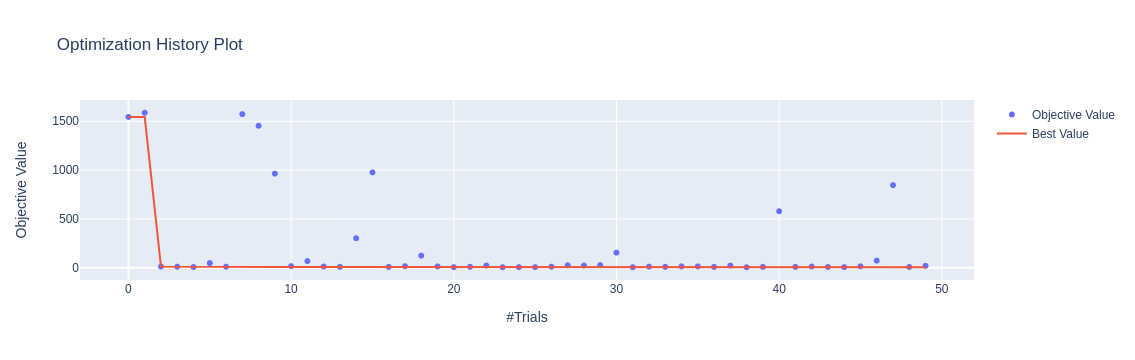

In [66]:
plot_optimization_history(study)

###### прекод для обучения нейронной модели

In [67]:
# обучим модель по указанным гиперпараметрам, и посмотрим результативность на тренировочной выборке

# LR = study.best_trial.params['lr']
# BATCH_SIZE = study.best_trial.params['batch_size']
# NUM_EPOCHS = study.best_trial.params['num_epochs']

In [68]:
# # обратим разбиение тренировочного и оценочного сетов
# X_train = np.concatenate([X_train, X_eval], axis=0)
# y_train = pd.Series(np.concatenate([y_train, y_eval], axis=0))
# train_dataset = Dataset(X_train, y_train, scaler, train=True)

In [69]:
# net = NeuralNet(n_neurons=[62, 32, 16, 1], dropout=0.)
# criterion = nn.L1Loss()
# optimizer = torch.optim.Adam(net.parameters(), lr=LR)

# for param in net.fc:
#     if isinstance(param, nn.Linear):
#         nn.init.kaiming_normal_(param.weight)
#         nn.init.uniform_(param.bias)
        
# display(net)

# train_list = []
# test_list = []

# train(net, optimizer, criterion,
#       train_list, test_list,
#       train_dataset, test_dataset, batch_size=BATCH_SIZE,
#       num_epochs=NUM_EPOCHS, print_every=10, verbose=True)

#### Шаг 4. Тестирование модели и демонстрирация

По итогам рассмотрения моделей (случайный лес, бустинг и нейронная сеть) лучшее значение целевого метрики было продемонтрировано бустингом, поэтому его мы и возмем в качестве результирующей модели для дальнейшей демонстрации

In [70]:
model_final = best_models['lgb']

In [71]:
print('Значение финальной модели целевой метрики MAE на тестовой выборке равно', round(mean_absolute_error(y_test, model_final.predict(X_test)), 3))
print('Значение финальной модели вспомогательной метрики R2 на тестовой выборке равно', round(r2_score(y_test, model_final.predict(X_test)), 3))

Значение финальной модели целевой метрики MAE на тестовой выборке равно 5.849
Значение финальной модели вспомогательной метрики R2 на тестовой выборке равно 0.468


In [72]:
print('Значение константной модели целевой метрики MAE на тестовой выборке равно', round(mean_absolute_error(y_test, dummy_model.predict(X_test)), 3))
print('Значение константной модели вспомогательной метрики R2 на тестовой выборке равно', round(r2_score(y_test, dummy_model.predict(X_test)), 3))

Значение константной модели целевой метрики MAE на тестовой выборке равно 8.031
Значение константной модели вспомогательной метрики R2 на тестовой выборке равно -0.001


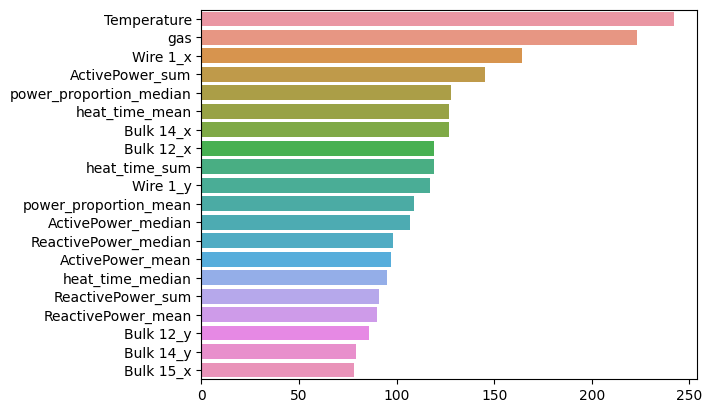

In [73]:
fe_series = pd.Series(model_final.feature_importances_,
                      index=X_train.columns)\
              .sort_values(ascending=False)[:20]

sns.barplot(x=fe_series, y=fe_series.index)
plt.show()

Как можно заметить по графику важности основных признаков, с весьма ощутимым отрывом лидируют первоначальная температура сплава (что выглядит весьма интуитивно понятным), а также информации о продуве газом (что, без сомнений, более специфический критерий). Кроме того высокой важностью также обозначились критерии связанные с электродами и, как следствие, со всеми промежуточными эпизодами нагревания. Значительно реже нам встречаются параметры связанные с конкретынми сыпучими и проволочными материалами.

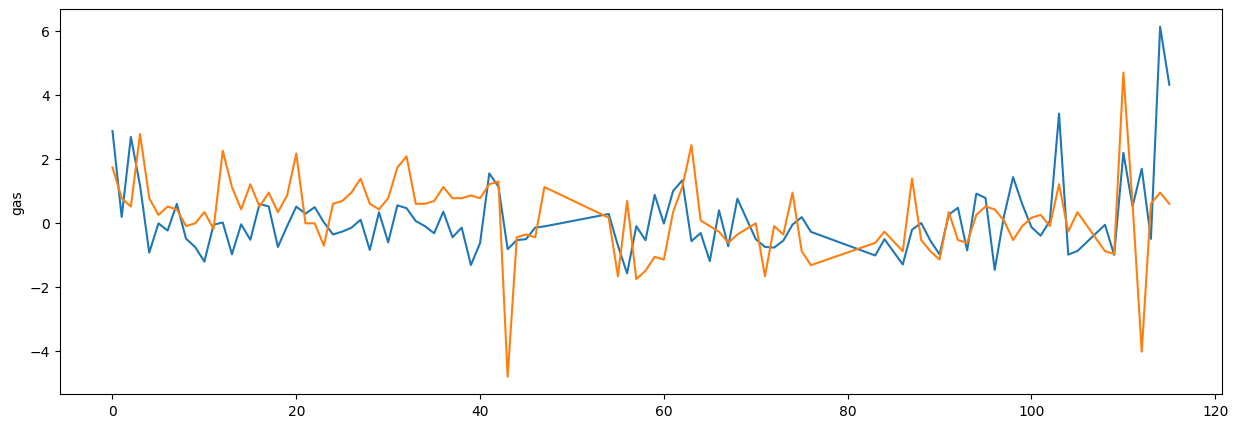

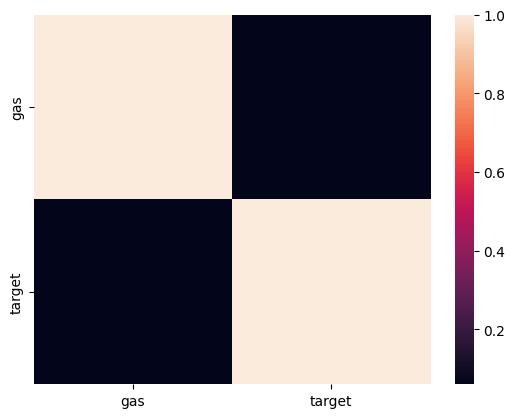

In [74]:
# рассмотрим зависимость параметра "газ" и целевой переменной 
# для демонстрации ограничимся первыми ста наблюдениями

plt.figure(figsize=(15, 5))
sns.lineplot(((features['gas']-features['gas'].mean())/features['gas'].std()).iloc[:100])
sns.lineplot(((target-target.mean())/target.std()).iloc[:100])
plt.show()

sns.heatmap(pd.concat([features['gas'], target], axis=1).corr())
plt.show()

Как подсказывает нам график, а затем уточняем корреляционная таблица - зависимость данных параметров едва напоминает линейную.

#### Шаг 5. Тестирование модели и демонстрирация

В данном проетке мы попытались обучить модель, способную предсказывать температуру партии в зависимости о ряда параметров, связанных с ее производственным процессом. Нам удалось достичь необходимого значения метрики MAE на тестовой выборке (< 6.8) и, в том числе, оценить адекватность модели, сравнив ее с dummy моделью. Как мы заметили, данные из таблицы data_arc весьма информативны для модели, поэтому для дальнейшей работы в данном направлении можно расммотреть по меньшей мере следующие шаги:
* генерация новых статистик на основе данной таблицы (разные скантили, коэффициенты скосов и т.п.);
* генерация "смыслового" вектора при помощи RNN и трансформеров.